In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')
import nltk

from tqdm.notebook import tqdm

df = pd.read_csv(r'C:\Users\Kireh Kaka\2024_OpenTable_Data_Cleaned.csv', encoding='latin1')

In [3]:
#Reversing the columns and changing Date to a datetime object

df_reversed = df.iloc[::-1].reset_index(drop=True)
df_reversed['Date'] = pd.to_datetime(df_reversed['Date'], format='%m/%d/%Y')

mean_ratings = df_reversed.resample('M', on='Date').mean().round(2)
print(mean_ratings)

            Food  Service  Ambience  Overall
Date                                        
2024-01-31  4.18     4.25      4.22     4.28
2024-02-29  4.29     4.46      4.43     4.57
2024-03-31  4.15     4.65      4.35     4.30
2024-04-30  4.24     4.48      4.29     4.24
2024-05-31  4.12     4.47      4.18     4.06
2024-06-30  4.38     4.23      4.31     4.31
2024-07-31  3.89     4.33      4.22     4.11
2024-08-31  3.60     4.20      3.80     3.60
2024-09-30  4.67     4.56      4.89     4.56
2024-10-31  3.68     4.00      4.05     3.79
2024-11-30  4.47     4.80      4.40     4.47
2024-12-31  4.30     4.35      4.25     4.35


<AxesSubplot:title={'center':'2024 Rating Count'}>

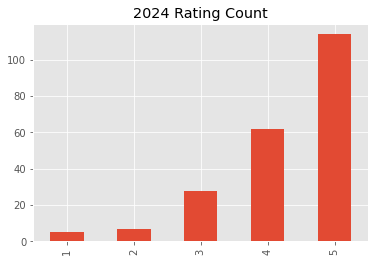

In [4]:
#Bar chart of ratings and their count


df['Overall'].value_counts().sort_index().plot(kind='bar',title='2024 Rating Count')

In [5]:
#Setting up RoBERTa

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [6]:
#Function to to get the polarity score and putting it in a dictionary

def polarity_scores(data):
    encoded_text = tokenizer(comment, return_tensors='pt')
    output = model(**encoded_text)
    score = output[0][0].detach().numpy()
    score = softmax(score)
    sc_dict = { 'negative' : score[0],
                'neutral' : score[1],
                'positive' : score[2]}
    return sc_dict
    

In [10]:
#iterating through the comments and applying the function

res = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
        try:
            comment = row['Comment']
            polarity_res = polarity_scores(comment)
            res[i] = polarity_res
            
        except RuntimeError:
            print(f'Broke for {i}')
        



  0%|          | 0/216 [00:00<?, ?it/s]

Broke for 3


In [26]:
#Test Example

example = df['Comment'][30]
print(example)
polarity_scores(example)


The food, service, drinks, and atmosphere were all wonderful! Will be back!


{'negative': 0.16793436, 'neutral': 0.31442788, 'positive': 0.51763767}

In [20]:
#Adding the results to the dataframe

results_df = pd.DataFrame(res).T  
results_df.index.name = 'index'
results_df.reset_index(inplace=True)

final_df = results_df.merge(df, left_on='index', right_index=True)

final_df


,index,negative,neutral,positive,Date,Comment,Food,Service,Ambience,Overall
0,0,0.001796,0.006687,0.991517,12/22/2024,"Loved it really good food and beautiful place,...",4,3,4,4
1,1,0.016621,0.114577,0.868803,12/22/2024,Nice variety of dishes - Cake slices too small...,4,4,4,4
2,2,0.001975,0.008194,0.989832,12/22/2024,Sunday brunch. Great fun as usual. Thanks again,5,5,5,5
3,4,0.001213,0.009690,0.989097,12/21/2024,"We eat often at Hot House and, as usual, we fo...",4,4,4,4
4,5,0.688229,0.248899,0.062872,12/21/2024,We rarely go out to eat these days due to the ...,2,4,2,3
...,...,...,...,...,...,...,...,...,...,...
210,211,0.001284,0.007653,0.991063,1/5/2024,The food was delicious and thanks for the spec...,5,5,5,5
211,212,0.001252,0.005817,0.992931,1/1/2024,It's our family tradition to have new year bru...,4,4,4,4
212,213,0.001576,0.013179,0.985245,1/1/2024,Great food and exceptional service. Very comfo...,5,5,5,5
213,214,0.001367,0.013579,0.985055,1/1/2024,A lovely place to go for New Years Day Brunch....,5,5,5,5


In [22]:
#Reviews with Server Names Mentioned

servers = ['Alex','Katie','Jenn','Daniela','Alyssa',
           'Sean','Kim','Jessica','Jesse','Maya','Antonia',
           'Sunil','Dana','Stephanie','Emily','Sophia','Scotty',
           'Aishwarya','Hannah','Patty']

server_comments = final_df[final_df['Comment'].str.contains('|'.join(servers), case=False, na=False)]
pd.set_option('display.max_colwidth', None)
display(server_comments)

,index,negative,neutral,positive,Date,Comment,Food,Service,Ambience,Overall
16,17,0.002733,0.009622,0.987645,12/3/2024,Wonderful business lunch at the HOT House and Sean our server was excellent. I have food allergies and he was wonderful. Will be back again,5,5,5,5
27,28,0.006510,0.079891,0.913599,11/9/2024,"Great evening, restaurant was full. Our server, Sean gave great advice. Our reservation wa for 7:45pm, we were seated on arrival and service was prompt. Noise level was high at beginning but settled as the evening progressed.",4,5,3,4
32,33,0.001153,0.007827,0.991020,11/2/2024,We were a party of six and had a wonderful supper at the HotHouse. The food was delicious and the service provided by Aishwarya and the dining room staff was perfect!,5,5,5,5
50,51,0.001548,0.011064,0.987388,9/12/2024,Food was really good; had the chicken curry and it was great. Scotty was excellent.,5,5,5,5
55,56,0.345006,0.419425,0.235569,9/26/2024,"We had good expectations based on previous reviews. We arrived at the restaurant and it wasn't busy at all. We ordered drinks and our food and that's when we waited a long time. It was nearly an hour before our food arrived. We noticed another customer arrived, ordered, ate, and left before we even received our entrees (and we were a small party). Our server, Dana, didn't seem to care. She never once mentioned a delay, apologized, asked if we needed much. She just brought more water. The food itself was average. Not bad, not special. But the lack of service was really noticeable.",3,1,4,2
58,59,0.001310,0.007451,0.991239,9/20/2024,"Our server Sunil was very attentive and it was a pleasure to be served by him. The food was served quickly, and was delicious! Thank you.",5,5,5,5
63,64,0.001111,0.005400,0.993489,8/17/2024,"It's a nice go-to place for brunch and hanging out with friends. We enjoyed a lovely long lunch, and Scotty, our server was amazing -- prompt, attentive, and charming. Looking forward to my next visit in my favorite booth.",5,5,5,5
94,95,0.001305,0.008820,0.989874,5/18/2024,Always enjoy our visits to The Hothouse however our last one was particularly enjoyable and memorable (in a very good way) because of our server Hannah ..... excellence in every way.,4,5,5,5
155,156,0.002301,0.027550,0.970149,2/21/2024,"The service was excellent but the Jumbalaya thought very tasty, skimped on the shrimp.",4,5,4,4
191,192,0.001259,0.007986,0.990755,1/19/2024,Excellent meal. Alex our server was very professional and friendly. Enjoyed our meal very much and will be back!,5,5,4,5


In [25]:
#Example case of RoBERTa not working as accurately :(

example2 = df['Comment'][56]
print(example2)
polarity_scores(example2)

# Comment seems to more negative than RoBERTa's scoring

We had good expectations based on previous reviews. We arrived at the restaurant and it wasn't busy at all. We ordered drinks and our food and that's when we waited a long time. It was nearly an hour before our food arrived. We noticed another customer arrived, ordered, ate, and left before we even received our entrees (and we were a small party). Our server, Dana, didn't seem to care. She never once mentioned a delay, apologized, asked if we needed much. She just brought more water. The food itself was average. Not bad, not special. But the lack of service was really noticeable.


{'negative': 0.16793436, 'neutral': 0.31442788, 'positive': 0.51763767}

In [30]:
#5 Star Service Reviews

fivestars = final_df[final_df['Overall']==5]
service_pos_comment = fivestars[fivestars['Comment'].str.contains('service',case=False,na=False)]

service5star = final_df[final_df['Service']==5]

In [31]:
#1 Star Service Reviews

onestars = final_df[final_df['Overall']==1]
service_neg_comment = onestars[onestars['Comment'].str.contains('service',case=False,na=False)]

service1star = final_df[final_df['Service']==1]

In [32]:
service_neg_comment

,index,negative,neutral,positive,Date,Comment,Food,Service,Ambience,Overall
124,125,0.625801,0.27196,0.102239,4/6/2024,"Unfortunately did not enjoy our time here, sat down at 5:30 (we had a reservation at 5:45 but they were able to seat us early which was good) and then proceeded to sit there for an hour with no food, one jug of water for the table only and no starters were brought out once we ordered. When we brought this to their attention they checked on our food and brought it immediately 2/3 dishes were warm but unfortunately one was cold. We were now late for our plans so we had to eat very quickly. Food that was hot was delicious but couldnt really be enjoyed due to how long we had to wait. Not sure what had happened and we understand that it was a busy Saturday, however we watched lots of tables recieve service and food far quicker. We have been here before and loved it hence our return. Unfortunately we dont think we will come back again, the taste of the food is not worth the cost and wait.",4,2,2,1


In [33]:
service1star

,index,negative,neutral,positive,Date,Comment,Food,Service,Ambience,Overall
55,56,0.345006,0.419425,0.235569,9/26/2024,"We had good expectations based on previous reviews. We arrived at the restaurant and it wasn't busy at all. We ordered drinks and our food and that's when we waited a long time. It was nearly an hour before our food arrived. We noticed another customer arrived, ordered, ate, and left before we even received our entrees (and we were a small party). Our server, Dana, didn't seem to care. She never once mentioned a delay, apologized, asked if we needed much. She just brought more water. The food itself was average. Not bad, not special. But the lack of service was really noticeable.",3,1,4,2
165,166,0.872565,0.111155,0.016281,2/14/2024,"We come to the HotHouse very often but this was our first time at valentines day. It was not a good experience: the dishes we ordered were sold out (even though we were there at 630pm) and our server was clearly overwhelmed. We felt we were always waiting to get our drinks, or trying to get her attention, we spent a ton of time there just drinking water my partner ordered the ribeye steak and it was very fatty, mostly inedible. We ended up cutting the night short and going elsewhere to get a drink a burger.",3,1,3,4
178,179,0.602625,0.290784,0.106591,1/27/2024,"Many people working there but no one seems to know their job. Six people at our table, meals came for five , sixth person waited an extra 10 minutes for their food to arrive, after WE mentioned it to our server. (Not even an apology) Place is outdated! Visiting the Hothouse for Sunday Brunch years ago was great, but this place is definitely on the decline.",2,1,1,2


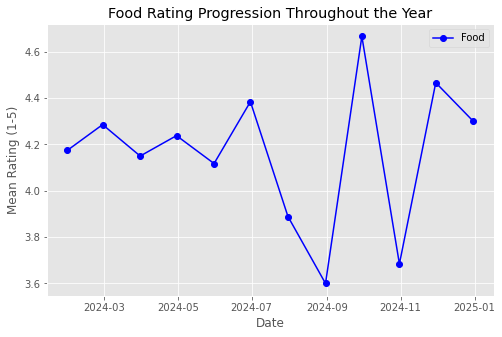

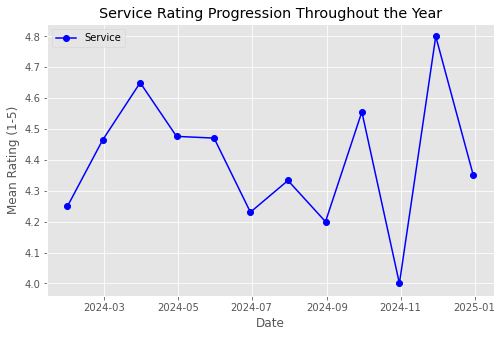

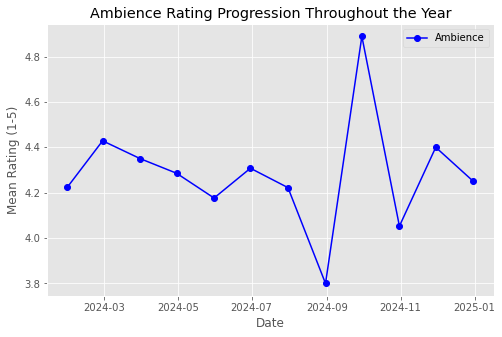

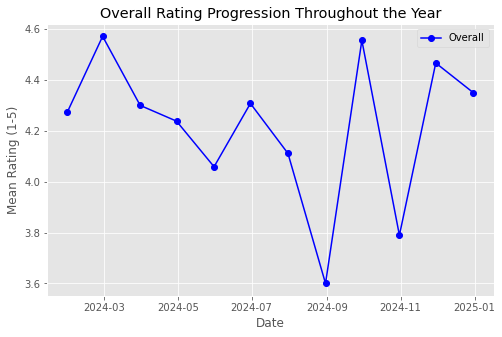

In [34]:
#Line chart of mean rating progression of Service, Food, Ambience and Overall throughout the year

mean_ratings = df_reversed.resample('M', on='Date').mean()


for column in ['Food', 'Service', 'Ambience', 'Overall']:
    plt.figure(figsize=(8, 5))
    plt.plot(mean_ratings.index, mean_ratings[column], label=column, color='b', marker='o')
    
    plt.title(f'{column} Rating Progression Throughout the Year')
    plt.xlabel('Date')
    plt.ylabel('Mean Rating (1-5)')
    plt.grid(True)
    plt.legend([column])
    
    plt.show()


In [35]:
# Finding Comments that refer to the Buffet and its Value for money

buffet_price = ['buffet', 'value', 'money',]
pattern = '|'.join(buffet_price)  

buffet_price_comments = final_df[
    final_df['Comment'].str.contains(pattern, case=False, na=False) &
    final_df['Comment'].str.contains('price', case=False, na=False)
]

buffet_price_comments


,index,negative,neutral,positive,Date,Comment,Food,Service,Ambience,Overall
37,38,0.124569,0.260427,0.615004,10/27/2024,Good service and kind staff. Good mediocre and overpriced brunch buffet.,2,3,3,3
52,53,0.183668,0.370318,0.446014,10/6/2024,"Food: To be honest, the food experience was a little disappointing we understand the idea of shrinking the buffet menu is a method to improve its quality. Unfortunately I didnt really see the improvement the roast beef was on the dryer side and by the time I walked my dish back to my table, the meat was already cold. I wanted a small piece of salmon Wellington but the server was too busy making an omelet for someone else so I didnt bother waiting. The salad bar was quite sad they tried making a nice seafood salad but it was just a few pieces of shrimp and calamari over a large bed of mixed greens, which did not seem appealing to us. There were only a handful of cheese and cold cuts selection as well at the charcuterie section. Also, no muffins or danishes to choose from very limited croissants and breakfast baked goods. The only thing that stood out to me was their delicious hot bread pudding. Otherwise, the mussels were alright and that was it. Service: We were greeted nicely once we arrived. The server kinda disappeared on us for a good chunk of time but, it didnt bother us too much our plates were still cleared in a timely manner but our coffees were running empty towards the end. She was quite friendly too. Atmosphere: The restaurant itself had a nice atmosphere, still had their Sunday brunch live jazz which was great. Customers were all pretty chill, there was a pleasant large party that were seated close by to our table. Lovely environment. To add to it, the restaurant had a face lift and its slightly more modern than pre pandemic days, overall pretty clean. Overall, Im not sure if we would be back anytime soon again. For the price tag, I expected a little more than what I experienced there on Sunday. I can see this being a great place to meet up and catch up with family and friends but dont expect the food to be superb.",2,3,4,2
60,61,0.622199,0.274764,0.103036,9/8/2024,Food is always amazing. The price has skyrocketed though making it not really worth the value. They already don't offer a big enough buffet. Now that it costs $45 pp its not worth it. The food was also running out and fresh items were not brought out quickly,4,5,5,4
62,63,0.940659,0.052434,0.006907,8/18/2024,The brunch buffet is so overrated. Not worth the price at all. None of the food had any seasoning. The food is made for old people and it showed in the crowd. Save your money and go to a real brunch spot.,1,3,2,1
81,82,0.000884,0.018037,0.981078,6/23/2024,"Sunday brunch, best in the City, so much variety! Plus, and awesome Jazz Band in the centre of the restaurant. Value for the price, a+",5,5,5,5
128,129,0.492196,0.398026,0.109778,3/31/2024,"Although this restaurant is easy to access using transit or other means, the menu is pedestrian at best. The set up is abstract. The carving station and omelet site are at the bar, while the remainder of the food that would go with these options is located in the back. I am not sure why the dessert and salads could not be at the bar, so that the mains were all located in one location. The food while good, is not special at all. There are limited salads, none with lettuce. The pasta is the salad was dry, not undercooked, just dry(left out too long). The cheese selection consited of 2 cheeses, both cheddar. Having cold salmon on a buffet is not special any more. The mains were ok, but again nothing fancy. At the carving station they offered leg of lamb, ham, roast beef(not prime rib) and salmon wellington. The beef was a bit tough and unfortunately the salmon wellington although looking good, was flaky on the ouside and wet and mushy on the inside. Not a great dish. The location is nice and the service was very good for a holiday buffet. My only comment is that althou